In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import PolynomialFeatures
from torch.autograd import Variable
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Create data

In [15]:
# Gaussian function
def gaussian(x, mu, sigma=1.0):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

def create_gaussian_polynomial_time_matrix(poly_func, rows=500, cols=50, sigma=1.0):
    matrix = np.zeros((rows, cols))
    
    t_values = np.linspace(-10, 10, cols)
    shift_values = poly_func(t_values)
    
    for col, delta in enumerate(shift_values):
        for i in range(rows):
            matrix[i, col] += gaussian(i, rows / 2 - delta, sigma)

    matrix /= np.max(matrix)
    
    return matrix

def generate_random_polynomial(degree, seed_number=None):
    np.random.seed(seed_number)
    coefficients = np.random.uniform(-10, 10, degree+1)
    polynomial = np.poly1d(coefficients)
    return polynomial

In [16]:
rows, cols, sigma = 500, 50, 5.0
degree = 2

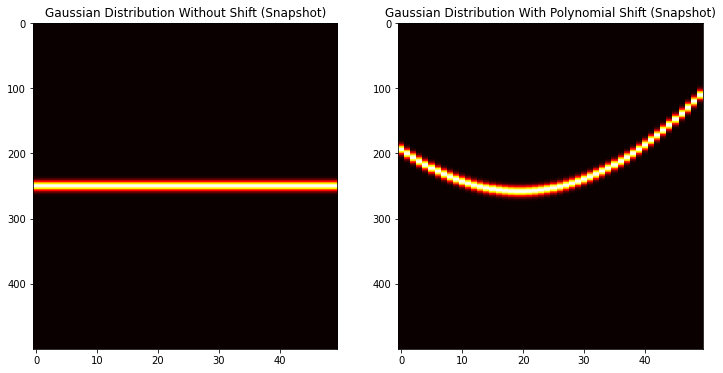

In [17]:
shift_polynom = generate_random_polynomial(2, seed_number=3)
Q_with_shift = create_gaussian_polynomial_time_matrix(shift_polynom, rows, cols, sigma)
Q_without_shift = create_gaussian_polynomial_time_matrix(lambda x: np.zeros_like(x, dtype=float), rows, cols, sigma)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Without shift
ax[0].imshow(Q_without_shift, cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Gaussian Distribution Without Shift (Snapshot)')

# With shift
ax[1].imshow(Q_with_shift, cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Gaussian Distribution With Polynomial Shift (Snapshot)')

plt.show()

## Split the data

In [18]:
indices = np.arange(cols)
np.random.seed(42)
np.random.shuffle(indices)
train_ratio = 0.8
train_size = int(cols * train_ratio)
test_size = cols - train_size
train_indices = indices[:train_size]
test_indices = indices[train_size:]
train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)
X_train, X_test = Q_without_shift[:, train_indices], Q_without_shift[:, test_indices]
y_train, y_test = Q_with_shift[:, train_indices], Q_with_shift[:, test_indices]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(500, 40) (500, 40) (500, 10) (500, 10)


In [31]:
# Create x^0,x^1,x^2,.. columns
x_train_flat = X_train.flatten()
X_train_poly = np.zeros((x_train_flat.shape[0],degree+1))
for i in range(x_train_flat.shape[0]):
    X_train_poly[i,0] = 1
    for j in range(1,degree+1):
        X_train_poly[i,j] = pow(x_train_flat[i],j)

In [32]:
# Create x^0,x^1,x^2,.. columns
x_test_flat = X_test.flatten()
X_test_poly = np.zeros((x_test_flat.shape[0],degree+1))
for i in range(x_test_flat.shape[0]):
    X_test_poly[i,0] = 1
    for j in range(1,degree+1):
        X_test_poly[i,j] = pow(x_test_flat[i],j)

In [33]:
X_train_tensor = torch.tensor(X_train_poly, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_poly, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

In [23]:
#X_train_tensor = torch.tensor(X_train.transpose(), dtype=torch.float32)
#y_train_tensor = torch.tensor(y_train.transpose(), dtype=torch.float32)
#X_test_tensor = torch.tensor(X_test.transpose(), dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test.transpose(), dtype=torch.float32)

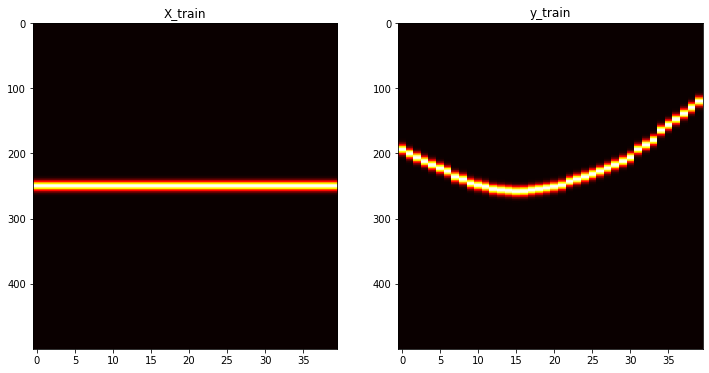

In [34]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Without shift
ax[0].imshow(X_train, cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('X_train')

# With shift
ax[1].imshow(y_train, cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('y_train')

plt.show()

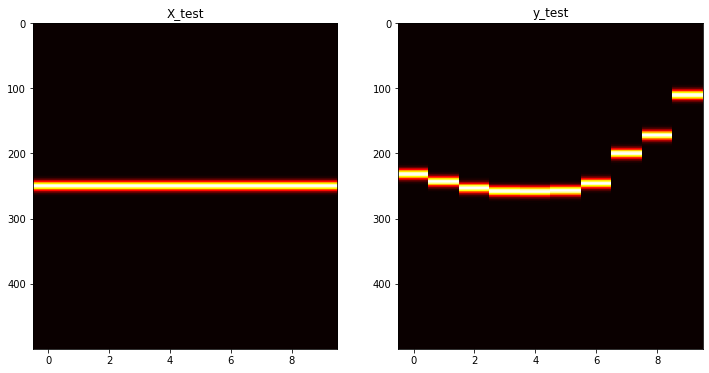

In [35]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Without shift
ax[0].imshow(X_test, cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('X_test')

# With shift
ax[1].imshow(y_test, cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('y_test')

plt.show()

## Define a model

In [36]:
class ShiftPredictionModel(nn.Module):
    def __init__(self, degree1, degree2, type_NN):
        super(ShiftPredictionModel, self).__init__()
        self.a_coefficients = nn.ParameterList(
            [nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) for _ in range(degree1+1)]
        )
        #self.b_coefficients = nn.ParameterList(
        #    [nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) for _ in range(degree2)]
        #)
        self.type_NN = type_NN
    
    def forward_pol(self,t):
        return sum([coeff * t**i for i, coeff in enumerate(self.a_coefficients)])
    
    def forward_rat(self,t):
        return self.forward_pol(t)/sum([coeff * t**i for i, coeff in enumerate(self.b_coefficients)])

    def forward_activ(self, t):
        return F.relu(t)
    
    def forward(self, t):
        if self.type_NN == "polynomial":
            output = self.forward_pol(t)
        elif self.type_NN == "rational":
            output = self.forward_rat(x)
            
        return output

# Initialize the network
model = ShiftPredictionModel(degree1=degree,degree2=0,type_NN="polynomial")
model.to(torch.float32)

ShiftPredictionModel(
  (a_coefficients): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1]
      (1): Parameter containing: [torch.float32 of size 1]
      (2): Parameter containing: [torch.float32 of size 1]
  )
)

## Train

In [37]:
def total_variation(shift):
    return torch.sum(torch.abs(shift[..., 1:] - shift[..., :-1]))

In [38]:
def calculate_loss(true_t,predicted_t,coefficients):
    predicted_shift = predicted_t @ coefficients
    return torch.max(torch.abs(true_t - predicted_t))

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 2000
for epoch in range(num_epochs):
    
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    a_coefficients_train = torch.tensor([p.item() for p in model.a_coefficients])
    prediction_loss = calculate_loss(y_train_tensor,predictions,a_coefficients_train)
    tv_loss=total_variation(predictions)
    loss = prediction_loss + 0.5 * tv_loss

    loss.backward()
    optimizer.step()
        
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions_test = model(X_test_tensor)
        a_coefficients_test = torch.tensor([p.item() for p in model.a_coefficients])
        prediction_test_loss = calculate_loss(y_test_tensor,predictions_test,a_coefficients_test).item()
        tv_test_loss = total_variation(predictions_test).item()
        test_loss = prediction_test_loss + 0.5 * tv_test_loss
        if epoch % 100 == 0:
            #a_coefficients = [p.item() for p in model.a_coefficients]  # Extract coefficients
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Coefficients:{[shift_polynom[i] for i in range(len(shift_polynom)+1)]}{a_coefficients_train}')


Epoch [0/2000], Loss: 6811.8604, Test Loss: 1704.7862, Coefficients:[-4.181905221741113, 4.162956452362096, 1.0159580514915092]tensor([ 2.3140,  1.9965, -1.2985])
Epoch [100/2000], Loss: 6617.3687, Test Loss: 1656.1475, Coefficients:[-4.181905221741113, 4.162956452362096, 1.0159580514915092]tensor([ 2.3040,  1.9865, -1.3085])
Epoch [200/2000], Loss: 6422.8394, Test Loss: 1607.4972, Coefficients:[-4.181905221741113, 4.162956452362096, 1.0159580514915092]tensor([ 2.2940,  1.9765, -1.3185])
Epoch [300/2000], Loss: 6228.9165, Test Loss: 1559.0064, Coefficients:[-4.181905221741113, 4.162956452362096, 1.0159580514915092]tensor([ 2.2840,  1.9665, -1.3285])
Epoch [400/2000], Loss: 6036.2119, Test Loss: 1510.8134, Coefficients:[-4.181905221741113, 4.162956452362096, 1.0159580514915092]tensor([ 2.2740,  1.9566, -1.3385])
Epoch [500/2000], Loss: 5843.2837, Test Loss: 1462.5627, Coefficients:[-4.181905221741113, 4.162956452362096, 1.0159580514915092]tensor([ 2.2640,  1.9466, -1.3484])
Epoch [600/2

## Evaluation

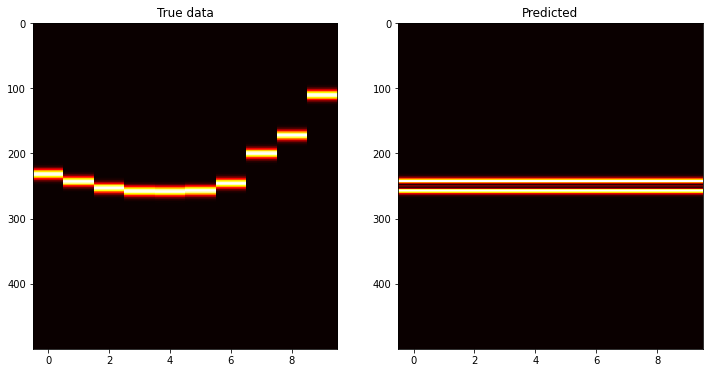

In [40]:
y_predicted = (predictions_test@a_coefficients_test).numpy().reshape(500,10)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Without shift
ax[0].imshow(y_test, cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('True data')

# With shift
ax[1].imshow(y_predicted, cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Predicted')

plt.show()